In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch

import triton
import triton.language as tl

In [3]:
def pack(x, n_bits=32):
    """
    pack n_bits of x into a single integer
    
    x: bool tensor (*, K, N)
    return: int tensor (*, K // n_bits, N)
    """
    assert x.shape[-2] % n_bits == 0, "K must be divisible by n_bits"

    shift = torch.arange(n_bits, device=x.device)
    shape = x.shape[:-2]
    x = x.view(-1, x.shape[-2]//n_bits, n_bits, x.shape[-1])
    x = x << shift[None, None, :, None]
    x = x.sum(-2)
    x = x.view(*shape, *x.shape[-2:])
    
    # determine dtype
    if n_bits == 8:
        dtype = torch.uint8
    elif n_bits == 16:
        dtype = torch.int16
    elif n_bits == 32:
        dtype = torch.int32
    elif n_bits == 64:
        dtype = torch.int64

    return x.to(dtype)

## 1-bit GEMM kernel

In [4]:
# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
# @triton.autotune(
#     configs=[
#         triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
#         triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
#         triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
#         triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
#         triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
#         triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
#         triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
#         triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
#     ],
#     key=['M', 'N', 'K'],
# )
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_1bit(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    n_bits,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), float
    B has shape (K//n_bits, N), int, packed boolean
    C has shape (M, N),
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    # b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # Adapted from GPTQ-Triton (https://github.com/fpgaminer/GPTQ-triton)
    # b_ptrs is set up such that it repeats elements along the K axis n_bits times
    b_ptrs = b_ptr + ((offs_k[:, None] // n_bits) * stride_bk + offs_bn[None, :] * stride_bn)   # (BLOCK_SIZE_K, BLOCK_SIZE_N)
    # shifter is used to extract each bit of each element in the int matrix
    shifter = (offs_k % n_bits)[:, None]

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        # b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0)
        b = tl.load(b_ptrs)

        # Convert B from int to a.dtype, for each bit in B, 0 becomes -1.0, 1 becomes 1.0
        # b: (BLOCK_SIZE_K, BLOCK_SIZE_N)
        b = (b >> shifter) & 0x1
        b = b.to(a.dtype) * 2 - 1
        
        # Simply convert to a.dtype
        # b = b.to(a.dtype)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        # b_ptrs += BLOCK_SIZE_K * stride_bk
        b_ptrs += (BLOCK_SIZE_K // n_bits) * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    # if ACTIVATION == "leaky_relu":
    #     accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)

For single GEMM:

A: activation matrix, shape (m, k)

B: weight matrix, shape (k, n)

Typical config: n = 11008, k = 4096, m = 1

For batch GEMM:

A: activation matrix, shape (b, m, k)

B: weight matrix, shape (b, k, n)

In [5]:
def matmul(a, b, n_bits=32, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0] * n_bits, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    assert b.is_contiguous(), "Matrix B must be contiguous"
    M, K = a.shape
    _, N = b.shape

    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=a.dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
    )

    # print(f"Launching kernel with M = {M}, N = {N}, K = {K}, n_bits = {n_bits}, activation = {activation}")

    matmul_kernel_1bit[grid](
        a, b, c,
        M, N, K,
        n_bits,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
        ACTIVATION=activation
    )
    return c

In [6]:
torch.manual_seed(0)
a = torch.randn((512, 512), device='cuda', dtype=torch.float16)
b = torch.randn((512, 512), device='cuda', dtype=torch.float16)
b = (b > 0.5)
triton_output = matmul(a, pack(b))
torch_output = torch.matmul(a, b.to(a.dtype)*2-1)
print(f"triton_output={triton_output}")
print(f"torch_output={torch_output}")
if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

triton_output=tensor([[-26.1719,  25.5469,  21.1406,  ...,  10.6797,  25.8594,   0.7783],
        [ 41.4375,  -6.4414,  10.1172,  ..., -15.6562,  -8.8906,   5.3672],
        [  4.3945,  41.6562,  -2.4551,  ..., -20.0156,  16.7656,   8.6797],
        ...,
        [ 12.0469,  33.4062,  -4.4023,  ..., -13.2969,  -4.8281,  15.6172],
        [ -2.7227,   7.0859, -16.8594,  ..., -27.3281,  17.0000,  -6.5547],
        [-43.4375,   5.7188,  -3.8984,  ...,  11.8594, -22.7031, -19.5469]],
       device='cuda:0', dtype=torch.float16)
torch_output=tensor([[-26.1719,  25.5469,  21.1406,  ...,  10.6797,  25.8594,   0.7783],
        [ 41.4375,  -6.4414,  10.1172,  ..., -15.6562,  -8.8906,   5.3672],
        [  4.3945,  41.6562,  -2.4551,  ..., -20.0156,  16.7656,   8.6797],
        ...,
        [ 12.0469,  33.4062,  -4.4023,  ..., -13.2969,  -4.8281,  15.6172],
        [ -2.7227,   7.0859, -16.8594,  ..., -27.3281,  17.0000,  -6.5547],
        [-43.4375,   5.7188,  -3.8984,  ...,  11.8594, -22.7031, 

# 1-bit batch GEMM kernel

In [7]:
def get_configs_io_bound():
    configs = []
    for num_stages in [2, 3, 4, 5, 6]:
        for block_m in [16, 32]:
            for block_k in [32, 64]:
                for block_n in [32, 64, 128, 256]:
                    num_warps = 2 if block_n <= 64 else 4
                    configs.append(
                        triton.Config({'BLOCK_SIZE_M': block_m, 'BLOCK_SIZE_N': block_n, 'BLOCK_SIZE_K': block_k, 'GROUP_SIZE_M': 8},
                               num_stages=num_stages, num_warps=num_warps))
    return configs

In [8]:
from triton.ops.matmul_perf_model import early_config_prune, estimate_matmul_time

In [9]:
# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
# @triton.autotune(
#     configs=[
#         triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
#         triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
#         triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
#         triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
#         triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
#         triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
#         triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
#         triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
#     ],
#     key=['M', 'N', 'K'],
# )
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=2),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def batch_matmul_kernel_1bit(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    n_bits,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    stride_batch_a, stride_batch_b, stride_batch_c,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (B, M, K), float
    B has shape (B, K//n_bits, N), int, packed boolean
    C has shape (B, M, N),
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    pid_batch = tl.program_id(axis=1)

    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak) + pid_batch * stride_batch_a
    # b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # Adapted from GPTQ-Triton (https://github.com/fpgaminer/GPTQ-triton)
    # b_ptrs is set up such that it repeats elements along the K axis n_bits times
    b_ptrs = b_ptr + ((offs_k[:, None] // n_bits) * stride_bk + offs_bn[None, :] * stride_bn) + pid_batch * stride_batch_b
    # (BLOCK_SIZE_K, BLOCK_SIZE_N)
    # shifter is used to extract each bit of each element in the int matrix
    shifter = (offs_k % n_bits)[:, None]

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        # b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0)
        b = tl.load(b_ptrs)

        # Convert B from int to a.dtype, for each bit in B, 0 becomes -1.0, 1 becomes 1.0
        # b: (BLOCK_SIZE_K, BLOCK_SIZE_N)
        b = (b >> shifter) & 0x1
        b = b.to(a.dtype) * 2 - 1
        
        # Simply convert to a.dtype
        # b = b.to(a.dtype)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        # b_ptrs += BLOCK_SIZE_K * stride_bk
        b_ptrs += (BLOCK_SIZE_K // n_bits) * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    # if ACTIVATION == "leaky_relu":
    #     accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :] + pid_batch * stride_batch_c
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)

In [10]:
def batch_matmul(a, b, n_bits=32, activation=""):
    # Check constraints.
    # a: (B, M, K)
    # b: (B, K, N)
    assert a.dim() == 3, "Matrix A must be 3D"
    assert b.dim() == 3, "Matrix B must be 3D"
    assert a.shape[2] == b.shape[1] * n_bits, "Incompatible dimensions"
    assert a.shape[0] == b.shape[0], "Incompatible batch dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    assert b.is_contiguous(), "Matrix B must be contiguous"
    B, M, K = a.shape
    _, _, N = b.shape

    # Allocates output.
    c = torch.empty((B, M, N), device=a.device, dtype=a.dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        B
    )

    # print(f"Launching kernel with M = {M}, N = {N}, K = {K}, n_bits = {n_bits}, activation = {activation}")

    batch_matmul_kernel_1bit[grid](
        a, b, c,
        M, N, K,
        n_bits,
        a.stride(1), a.stride(2),
        b.stride(1), b.stride(2),
        c.stride(1), c.stride(2),
        a.stride(0), b.stride(0), c.stride(0),
        ACTIVATION=activation
    )
    return c

In [11]:
# torch.manual_seed(0)
a = torch.randn((16, 128, 512), device='cuda', dtype=torch.float16)
b = torch.randn((16, 512, 1024), device='cuda', dtype=torch.float16)
b = (b > 0.5)
triton_output = batch_matmul(a, pack(b))
torch_output = torch.bmm(a, b.to(a.dtype)*2-1)
# print(f"triton_output={triton_output}")
# print(f"torch_output={torch_output}")
if torch.allclose(triton_output, torch_output, rtol=1e-2, atol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

✅ Triton and Torch match


In [12]:
((triton_output - torch_output) / torch_output).abs().max()

tensor(0.0062, device='cuda:0', dtype=torch.float16)

## Speed test

### M (num_token per step) = 1

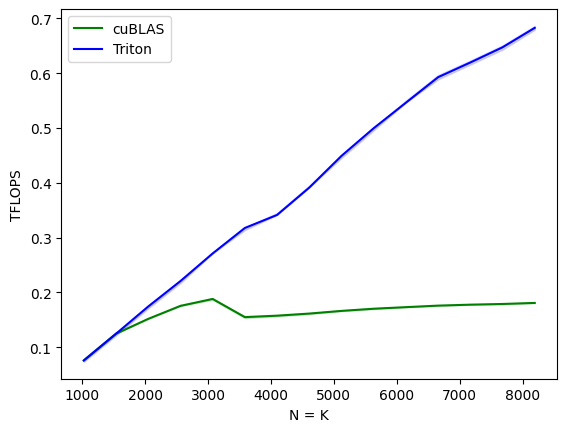

matmul-performance:
         N    cuBLAS    Triton
0   1024.0  0.075852  0.075852
1   1536.0  0.124541  0.124541
2   2048.0  0.151704  0.174298
3   2560.0  0.175342  0.220690
4   3072.0  0.188082  0.271059
5   3584.0  0.154864  0.317570
6   4096.0  0.157538  0.341333
7   4608.0  0.161370  0.391245
8   5120.0  0.166234  0.449123
9   5632.0  0.170198  0.499613
10  6144.0  0.173070  0.546133
11  6656.0  0.175870  0.592658
12  7168.0  0.177614  0.619457
13  7680.0  0.178882  0.647191
14  8192.0  0.180789  0.682667


In [13]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            512 * i for i in range(2, 17)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton'],
        # Label name for the lines
        line_names=["cuBLAS", "Triton"],
        # Line styles
        styles=[('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={"M": 1},
    )
)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16)
    b = (b > 0.5)
    b_pack = pack(b)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, 2 * b.to(a.dtype) - 1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b_pack), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

### M = 16

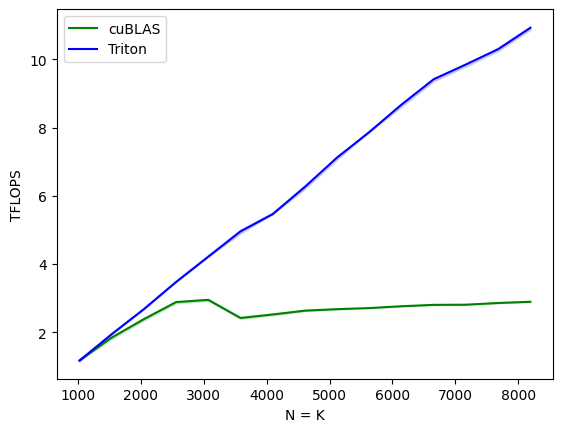

matmul-performance:
         N    cuBLAS     Triton
0   1024.0  1.170286   1.170286
1   1536.0  1.843200   1.940211
2   2048.0  2.383127   2.674939
3   2560.0  2.884507   3.471186
4   3072.0  2.949120   4.213028
5   3584.0  2.418121   4.955654
6   4096.0  2.520615   5.461333
7   4608.0  2.633143   6.259925
8   5120.0  2.677124   7.123478
9   5632.0  2.708284   7.866921
10  6144.0  2.762642   8.673882
11  6656.0  2.802526   9.418014
12  7168.0  2.807049   9.850503
13  7680.0  2.857674  10.297207
14  8192.0  2.892623  10.922666


In [14]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            512 * i for i in range(2, 17)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton'],
        # Label name for the lines
        line_names=["cuBLAS", "Triton"],
        # Line styles
        styles=[('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={"M": 16},
    )
)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16)
    b = (b > 0.5)
    b_pack = pack(b)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, 2 * b.to(a.dtype) - 1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b_pack), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

Batch

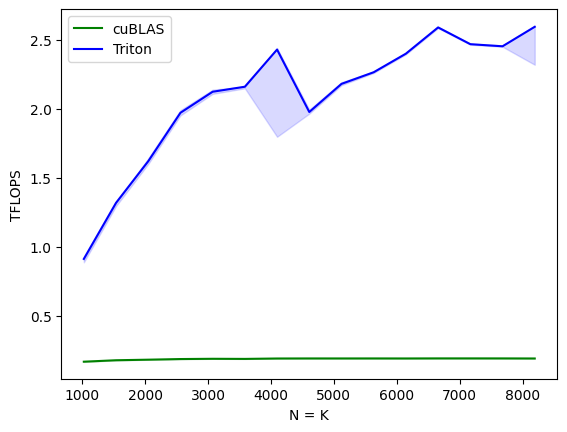

matmul-performance:
         N    cuBLAS    Triton
0   1024.0  0.165495  0.910222
1   1536.0  0.175962  1.316571
2   2048.0  0.180044  1.618173
3   2560.0  0.184671  1.969231
4   3072.0  0.186535  2.121669
5   3584.0  0.185708  2.158107
6   4096.0  0.188593  2.427259
7   4608.0  0.188992  1.974857
8   5120.0  0.188930  2.178723
9   5632.0  0.189058  2.263087
10  6144.0  0.188834  2.397658
11  6656.0  0.189365  2.587753
12  7168.0  0.189366  2.466409
13  7680.0  0.189240  2.451064
14  8192.0  0.188712  2.592277


In [15]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            512 * i for i in range(2, 17)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton'],
        # Label name for the lines
        line_names=["cuBLAS", "Triton"],
        # Line styles
        styles=[('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={"M": 1, "B": 16},
    )
)
def benchmark(B, M, N, K, provider):
    a = torch.randn((B, M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((B, K, N), device='cuda', dtype=torch.float16)
    b = (b > 0.5)
    b_pack = pack(b)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.bmm(a, 2 * b.to(a.dtype) - 1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: batch_matmul(a, b_pack), quantiles=quantiles)
    perf = lambda ms: 2 * B * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

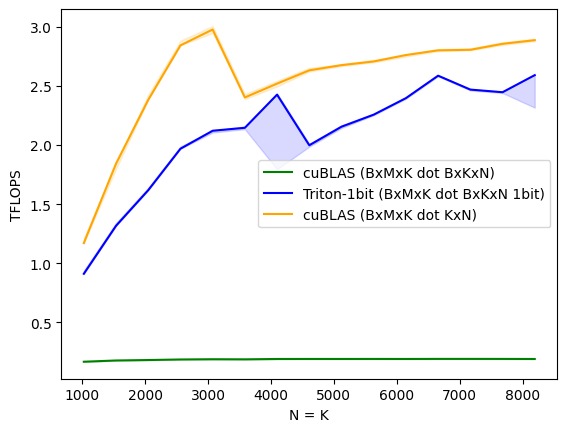

matmul-performance:
         N  cuBLAS (BxMxK dot BxKxN)  Triton-1bit (BxMxK dot BxKxN 1bit)  \
0   1024.0                  0.165495                            0.910222   
1   1536.0                  0.175962                            1.316571   
2   2048.0                  0.179797                            1.618173   
3   2560.0                  0.184505                            1.969231   
4   3072.0                  0.186535                            2.121669   
5   3584.0                  0.185708                            2.146567   
6   4096.0                  0.188661                            2.427259   
7   4608.0                  0.188992                            1.998651   
8   5120.0                  0.188930                            2.155789   
9   5632.0                  0.189094                            2.257932   
10  6144.0                  0.188865                            2.397658   
11  6656.0                  0.189417                            2.58

In [25]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            512 * i for i in range(2, 17)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton', 'cublas_no_batch'],
        # Label name for the lines
        line_names=["cuBLAS (BxMxK dot BxKxN)", "Triton-1bit (BxMxK dot BxKxN 1bit)", "cuBLAS (BxMxK dot KxN)"],
        # Line styles
        styles=[('green', '-'), ('blue', '-'), ('orange', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={"M": 1, "B": 16},
    )
)
def benchmark(B, M, N, K, provider):
    a = torch.randn((B, M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((B, K, N), device='cuda', dtype=torch.float16)
    b = (b > 0.5)
    b_pack = pack(b)
    quantiles = [0.5, 0.2, 0.8]

    result_triton = batch_matmul(a, b_pack)
    result_torch = torch.bmm(a, b.to(a.dtype)*2-1)

    # print(f"Rel diff = {(result_triton - result_torch).abs().mean() / result_torch.abs().mean()}")
    assert (result_triton - result_torch).abs().mean() / result_torch.abs().mean() < 1e-2

    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.bmm(a, 2 * b.to(a.dtype) - 1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: batch_matmul(a, b_pack), quantiles=quantiles)
    if provider == 'cublas_no_batch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, 2 * b[0].to(a.dtype) - 1), quantiles=quantiles)
    perf = lambda ms: 2 * B * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

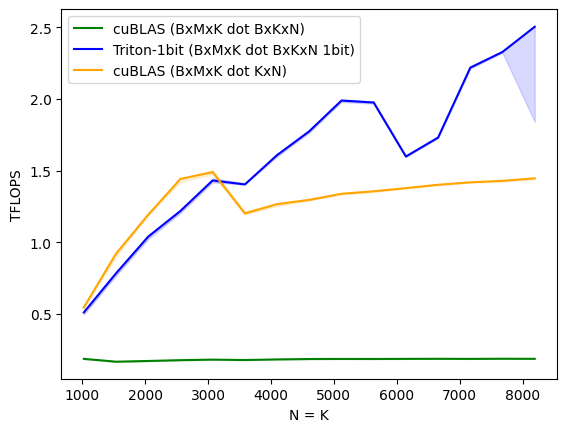

matmul-performance:
         N  cuBLAS (BxMxK dot BxKxN)  Triton-1bit (BxMxK dot BxKxN 1bit)  \
0   1024.0                  0.188322                            0.512000   
1   1536.0                  0.168329                            0.784340   
2   2048.0                  0.173376                            1.040254   
3   2560.0                  0.179021                            1.219048   
4   3072.0                  0.182721                            1.431612   
5   3584.0                  0.180004                            1.403525   
6   4096.0                  0.184219                            1.608245   
7   4608.0                  0.187021                            1.774203   
8   5120.0                  0.187503                            1.988350   
9   5632.0                  0.187308                            1.974566   
10  6144.0                  0.188082                            1.598439   
11  6656.0                  0.188514                            1.73

In [26]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            512 * i for i in range(2, 17)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton', 'cublas_no_batch'],
        # Label name for the lines
        line_names=["cuBLAS (BxMxK dot BxKxN)", "Triton-1bit (BxMxK dot BxKxN 1bit)", "cuBLAS (BxMxK dot KxN)"],
        # Line styles
        styles=[('green', '-'), ('blue', '-'), ('orange', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={"M": 1, "B": 8},
    )
)
def benchmark(B, M, N, K, provider):
    a = torch.randn((B, M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((B, K, N), device='cuda', dtype=torch.float16)
    b = (b > 0.5)
    b_pack = pack(b)
    quantiles = [0.5, 0.2, 0.8]

    result_triton = batch_matmul(a, b_pack)
    result_torch = torch.bmm(a, b.to(a.dtype)*2-1)

    # print(f"Rel diff = {(result_triton - result_torch).abs().mean() / result_torch.abs().mean()}")
    assert (result_triton - result_torch).abs().mean() / result_torch.abs().mean() < 1e-2

    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.bmm(a, 2 * b.to(a.dtype) - 1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: batch_matmul(a, b_pack), quantiles=quantiles)
    if provider == 'cublas_no_batch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, 2 * b[0].to(a.dtype) - 1), quantiles=quantiles)
    perf = lambda ms: 2 * B * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

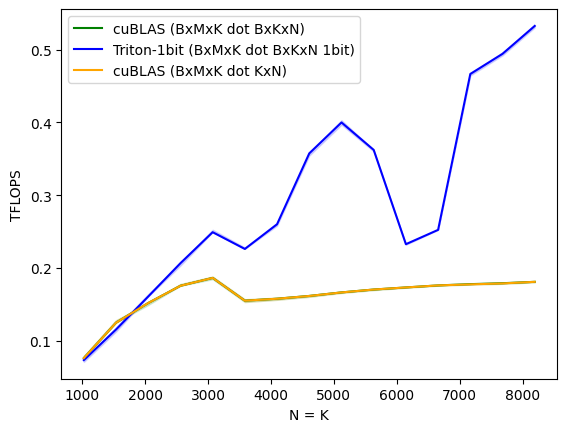

matmul-performance:
         N  cuBLAS (BxMxK dot BxKxN)  Triton-1bit (BxMxK dot BxKxN 1bit)  \
0   1024.0                  0.075852                            0.073143   
1   1536.0                  0.124541                            0.115200   
2   2048.0                  0.151704                            0.160627   
3   2560.0                  0.175342                            0.206452   
4   3072.0                  0.186182                            0.249081   
5   3584.0                  0.154864                            0.226018   
6   4096.0                  0.157538                            0.260063   
7   4608.0                  0.161370                            0.357517   
8   5120.0                  0.166234                            0.400000   
9   5632.0                  0.170198                            0.362292   
10  6144.0                  0.173070                            0.232580   
11  6656.0                  0.175870                            0.25

In [27]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            512 * i for i in range(2, 17)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton', 'cublas_no_batch'],
        # Label name for the lines
        line_names=["cuBLAS (BxMxK dot BxKxN)", "Triton-1bit (BxMxK dot BxKxN 1bit)", "cuBLAS (BxMxK dot KxN)"],
        # Line styles
        styles=[('green', '-'), ('blue', '-'), ('orange', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={"M": 1, "B": 1},
    )
)
def benchmark(B, M, N, K, provider):
    a = torch.randn((B, M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((B, K, N), device='cuda', dtype=torch.float16)
    b = (b > 0.5)
    b_pack = pack(b)
    quantiles = [0.5, 0.2, 0.8]

    result_triton = batch_matmul(a, b_pack)
    result_torch = torch.bmm(a, b.to(a.dtype)*2-1)

    # print(f"Rel diff = {(result_triton - result_torch).abs().mean() / result_torch.abs().mean()}")
    assert (result_triton - result_torch).abs().mean() / result_torch.abs().mean() < 1e-2

    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.bmm(a, 2 * b.to(a.dtype) - 1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: batch_matmul(a, b_pack), quantiles=quantiles)
    if provider == 'cublas_no_batch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, 2 * b[0].to(a.dtype) - 1), quantiles=quantiles)
    perf = lambda ms: 2 * B * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

## Appendix: Verify pack and unpack

In [16]:
# test
@triton.jit
def unpack_kernel(
    x_ptr, 
    output_ptr,
    n_bits,
    stride_k,
    stride_n,
    BLOCK_SIZE_K: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
):
    pid_k = tl.program_id(axis=0)
    pid_n = tl.program_id(axis=1)


    x_ptrs = x_ptr + ((pid_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K))[:, None] // n_bits * stride_k + (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N))[None, :] * stride_n)
    b = tl.load(x_ptrs)
    shifter = (tl.arange(0, BLOCK_SIZE_K) % n_bits)[:, None]
    b = (b >> shifter) & 0x1
    b = b.to(tl.int32)

    output_ptrs = output_ptr + (pid_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K))[:, None] * stride_k + (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N))[None, :] * stride_n
    tl.store(output_ptrs, b)

In [17]:
def unpack(x, n_bits=8):
    K, N = x.shape
    assert x.is_contiguous(), "Matrix x must be contiguous"
    output = torch.empty((K * n_bits, N), device=x.device, dtype=torch.int32)
    grid = lambda META: (
        triton.cdiv(K*n_bits, META['BLOCK_SIZE_K']),
        triton.cdiv(N, META['BLOCK_SIZE_N']),
    )
    unpack_kernel[grid](
        x, 
        output,
        n_bits,
        x.stride(0),
        x.stride(1),
        BLOCK_SIZE_K=32,
        BLOCK_SIZE_N=256,
    )
    return output